# 1. import Library

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

In [3]:
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

In [4]:
pip install plotly

In [5]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible
tensorflow.random.set_seed(1)
from numpy.random import seed
seed(1)

# 2. Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
train = pd.read_csv ("/content/drive/My Drive/fdai-test/train.csv")
test = pd.read_csv ("/content/drive/My Drive/fdai-test/test.csv")
factory_metadata = pd.read_csv ("/content/drive/My Drive/fdai-test/factory_metadata.csv")
sample_submission = pd.read_csv ("/content/drive/My Drive/fdai-test/sample_submission.csv")
weather_info = pd.read_csv ("/content/drive/My Drive/fdai-test/weather_info.csv")

In [7]:
train.head()

,factory_id,timestamp,target
0,0,2016-01-01 00:00:00,0.0
1,1,2016-01-01 00:00:00,0.0
2,2,2016-01-01 00:00:00,0.0
3,3,2016-01-01 00:00:00,0.0
4,4,2016-01-01 00:00:00,0.0


In [8]:
# train 데이터와 factory_metadata 병합
train_merge = pd.merge(train,factory_metadata, how='left',on='factory_id')
# train_merge와 weather_info 병합
train_merge = pd.merge(train_merge, weather_info, how='left', on=['location_id','timestamp'])
train_merge

,factory_id,timestamp,target,location_id,usage,square_meter,year_built,floor_count,temperature,cloud,dewpoint,rain,pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,0.000,0,0,690,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,2016-01-01 00:00:00,0.000,0,0,252,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,2016-01-01 00:00:00,0.000,0,0,499,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,2016-01-01 00:00:00,0.000,0,0,2200,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,2016-01-01 00:00:00,0.000,0,0,10833,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9095335,1444,2016-12-23 23:00:00,10.525,15,1,1822,1914.0,NaN,1.1,0.0,-6.1,NaN,1027.8,140.0,3.1
9095336,1445,2016-12-23 23:00:00,4.925,15,0,399,NaN,NaN,1.1,0.0,-6.1,NaN,1027.8,140.0,3.1
9095337,1446,2016-12-23 23:00:00,0.000,15,1,1046,1997.0,NaN,1.1,0.0,-6.1,NaN,1027.8,140.0,3.1
9095338,1447,2016-12-23 23:00:00,150.325,15,4,2766,2001.0,NaN,1.1,0.0,-6.1,NaN,1027.8,140.0,3.1


In [9]:
# test 데이터와 factory_metadata 병합
test_merge = pd.merge(test,factory_metadata, how='left',on='factory_id')
# test_merge weather_info 병합
test_merge = pd.merge(test_merge, weather_info, how='left', on=['location_id','timestamp'])
test_merge

,factory_id,timestamp,location_id,usage,square_meter,year_built,floor_count,temperature,cloud,dewpoint,rain,pressure,wind_direction,wind_speed
0,0,2016-01-24 00:00:00,0,0,690,2008.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7
1,1,2016-01-24 00:00:00,0,0,252,2004.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7
2,2,2016-01-24 00:00:00,0,0,499,1991.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7
3,3,2016-01-24 00:00:00,0,0,2200,2002.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7
4,4,2016-01-24 00:00:00,0,0,10833,1975.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965565,1444,2016-12-31 23:00:00,15,1,1822,1914.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
2965566,1445,2016-12-31 23:00:00,15,0,399,NaN,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
2965567,1446,2016-12-31 23:00:00,15,1,1046,1997.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
2965568,1447,2016-12-31 23:00:00,15,4,2766,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


In [10]:
train_merge["timestamp"]= pd.to_datetime(train_merge["timestamp"])
test_merge["timestamp"]= pd.to_datetime(test_merge["timestamp"])

In [11]:
# 월, 일, 요일, 주말여부, 시간 추가
train_merge['month']=train_merge['timestamp'].apply(lambda x: x.month)
train_merge['day']=train_merge['timestamp'].apply(lambda x: x.day)

# 평일=0~4, 주말=5~6
train_merge['weekday']=train_merge['timestamp'].apply(lambda x :x.weekday())

# 평일=0, 주말=1
train_merge['weekend']=train_merge['weekday'].apply(lambda x: 0 if x < 4 else 1)

# 시간
train_merge['hour']=train_merge['timestamp'].apply(lambda x: x.hour)

In [12]:
# 월, 일, 요일, 주말여부, 시간 추가
test_merge['month']=test_merge['timestamp'].apply(lambda x: x.month)
test_merge['day']=test_merge['timestamp'].apply(lambda x: x.day)

# 평일=0~4, 주말=5~6
test_merge['weekday']=test_merge['timestamp'].apply(lambda x :x.weekday())

# 평일=0, 주말=1
test_merge['weekend']=test_merge['weekday'].apply(lambda x: 0 if x < 4 else 1)

# 시간
test_merge['hour']=test_merge['timestamp'].apply(lambda x: x.hour)

# 3. EDA

In [ ]:
daily = train.groupby('timestamp', as_index=False)['target'].mean()
daily

,timestamp,target
0,2016-01-01 00:00:00,105.761506
1,2016-01-01 01:00:00,120.172984
2,2016-01-01 02:00:00,120.153222
3,2016-01-01 03:00:00,120.308740
4,2016-01-01 04:00:00,120.591857
...,...,...
6619,2016-12-23 19:00:00,161.569884
6620,2016-12-23 20:00:00,158.807285
6621,2016-12-23 21:00:00,155.430068
6622,2016-12-23 22:00:00,151.389001


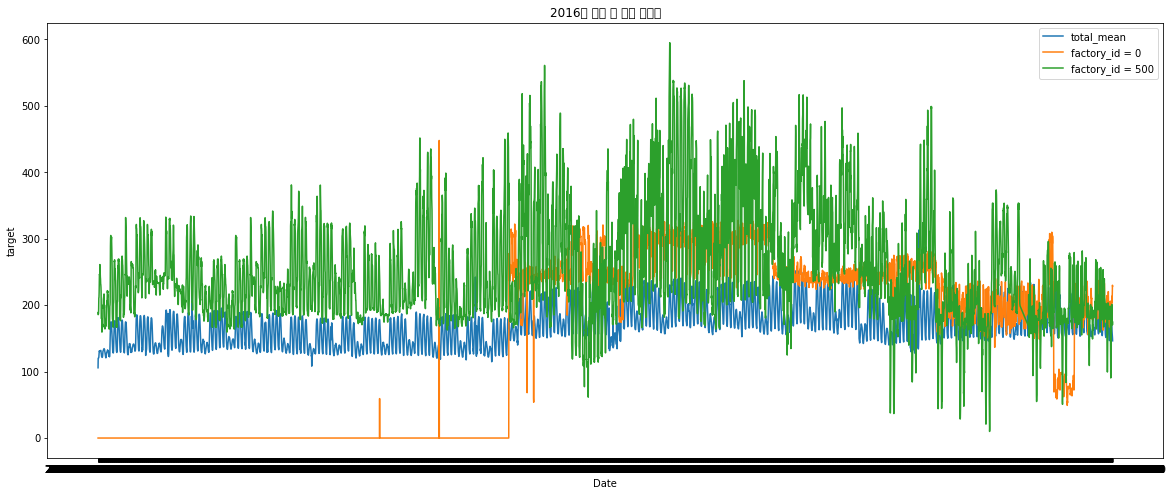

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(daily['timestamp'], daily['target'], label='total_mean')
plt.plot(train[train['factory_id']==0]['timestamp'], train[train['factory_id']==0]['target'], label='factory_id = 0')
plt.plot(train[train['factory_id']==500]['timestamp'], train[train['factory_id']==500]['target'], label='factory_id = 500')
plt.title('2016년 날짜 별 석유 소모량')
plt.xlabel('Date')
plt.ylabel('target')
plt.legend()

In [ ]:
# 전반적으로 여름(6-10월) 사이에 석유 소모량이 많고, 4월에 제일 적은 것으로 보인다.

In [ ]:
train_merge.groupby(['month'], sort=False)['timestamp'].agg('count')

month
1     764490
2     731466
3     706986
4     768129
5     767167
6     767829
7     766452
8     758994
9     772437
10    772793
11    766852
12    751745
Name: timestamp, dtype: int64

In [ ]:
train_merge.groupby(['month'], sort=False)['timestamp'].max()

month
1    2016-01-23 23:00:00
2    2016-02-23 23:00:00
3    2016-03-23 23:00:00
4    2016-04-23 23:00:00
5    2016-05-23 23:00:00
6    2016-06-23 23:00:00
7    2016-07-23 23:00:00
8    2016-08-23 23:00:00
9    2016-09-23 23:00:00
10   2016-10-23 23:00:00
11   2016-11-23 23:00:00
12   2016-12-23 23:00:00
Name: timestamp, dtype: datetime64[ns]

In [ ]:
test_merge.groupby(['month'], sort=False)['timestamp'].max()

month
1    2016-01-31 23:00:00
2    2016-02-29 23:00:00
3    2016-03-31 23:00:00
4    2016-04-30 23:00:00
5    2016-05-31 23:00:00
6    2016-06-30 23:00:00
7    2016-07-31 23:00:00
8    2016-08-31 23:00:00
9    2016-09-30 23:00:00
10   2016-10-31 23:00:00
11   2016-11-30 23:00:00
12   2016-12-31 23:00:00
Name: timestamp, dtype: datetime64[ns]

In [ ]:
test_merge.groupby(['month'], sort=False)['timestamp'].min()

month
1    2016-01-24
2    2016-02-24
3    2016-03-24
4    2016-04-24
5    2016-05-24
6    2016-06-24
7    2016-07-24
8    2016-08-24
9    2016-09-24
10   2016-10-24
11   2016-11-24
12   2016-12-24
Name: timestamp, dtype: datetime64[ns]

In [ ]:
predict_day = test_merge.groupby(['month'], sort=False)['timestamp'].max().dt.day-test_merge.groupby(['month'], sort=False)['timestamp'].min().dt.day
predict_day

month
1     7
2     5
3     7
4     6
5     7
6     6
7     7
8     7
9     6
10    7
11    6
12    7
Name: timestamp, dtype: int64

In [ ]:
(7+5+7+6+7+6+7+7+6+7+6+7)/12

6.5

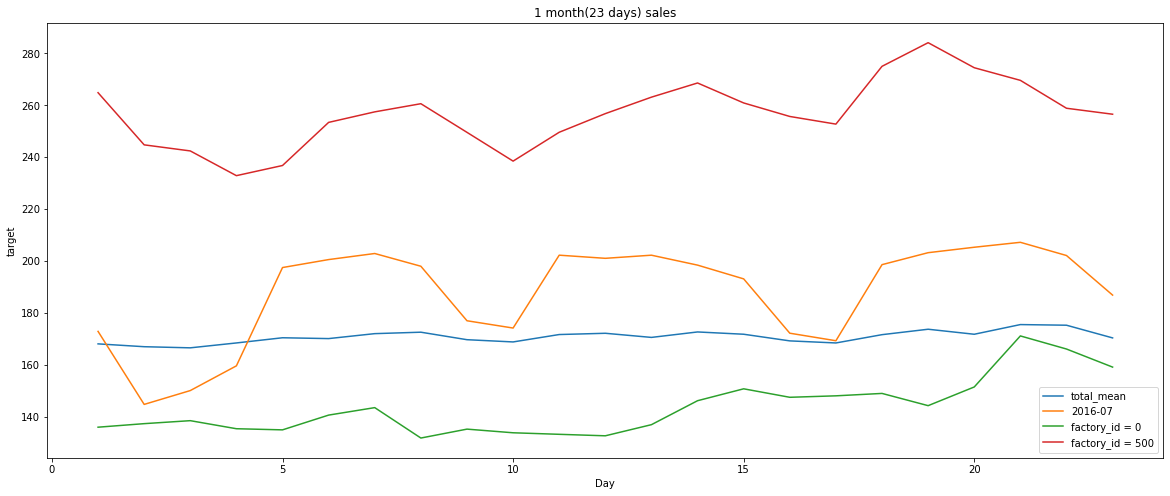

In [ ]:
plt.figure(figsize=(20,8))
monthly = train_merge.groupby('day', as_index=False)['target'].mean()
plt.plot(monthly['day'], monthly['target'], label='total_mean')

monthly_7 = train_merge[train_merge['month']==7].groupby('day', as_index=False)['target'].mean()
plt.plot(monthly_7['day'], monthly_7['target'], label='2016-07')

monthly_0 = train_merge[train_merge['factory_id']==0].groupby('day', as_index=False)['target'].mean()
plt.plot(monthly_0['day'], monthly_0['target'], label='factory_id = 0')
monthly_500 = train_merge[train_merge['factory_id']==500].groupby('day', as_index=False)['target'].mean()
plt.plot(monthly_500['day'], monthly_500['target'], label='factory_id = 500')
                           
plt.title('1 month(23 days) sales')
plt.xlabel('Day')
plt.ylabel('target')
plt.legend()

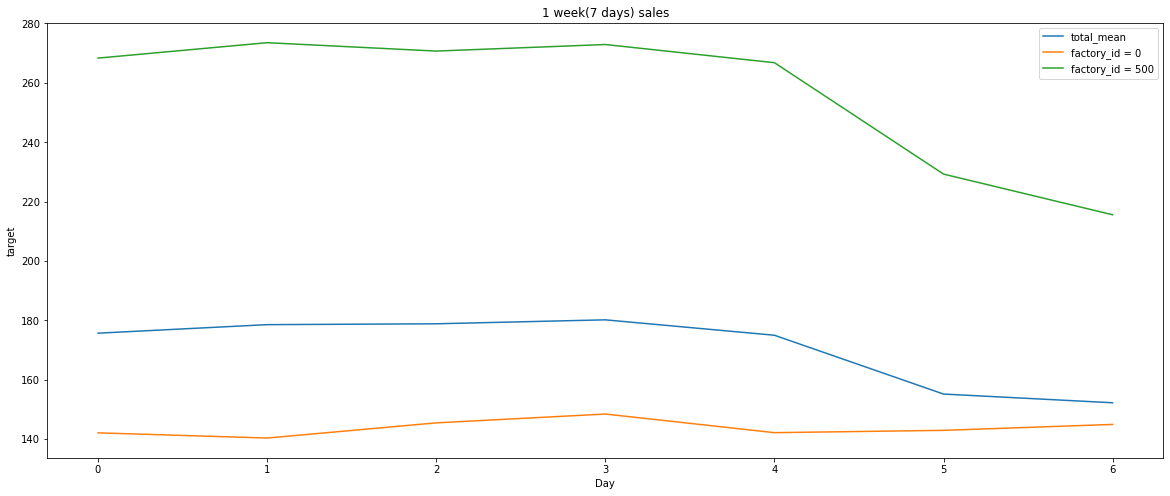

In [ ]:
plt.figure(figsize=(20,8))
weekly = train_merge.groupby('weekday', as_index=False)['target'].mean()
plt.plot(weekly['weekday'], weekly['target'], label='total_mean')

weekly_0 = train_merge[train_merge['factory_id']==0].groupby('weekday', as_index=False)['target'].mean()
plt.plot(weekly_0['weekday'], weekly_0['target'], label='factory_id = 0')
weekly_500 = train_merge[train_merge['factory_id']==500].groupby('weekday', as_index=False)['target'].mean()
plt.plot(weekly_500['weekday'], weekly_500['target'], label='factory_id = 500')
                           
plt.title('1 week(7 days) sales')
plt.xlabel('Day')
plt.ylabel('target')
plt.legend()

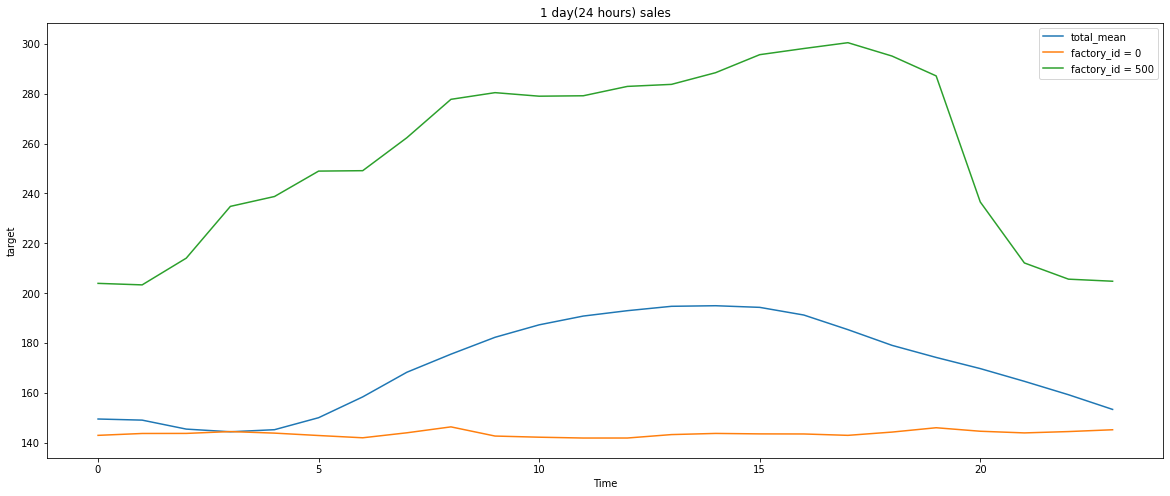

In [ ]:
plt.figure(figsize=(20,8))
hourly = train_merge.groupby('hour', as_index=False)['target'].mean()
plt.plot(hourly['hour'], hourly['target'], label='total_mean')

hourly_0 = train_merge[train_merge['factory_id']==0].groupby('hour', as_index=False)['target'].mean()
plt.plot(hourly_0['hour'], hourly_0['target'], label='factory_id = 0')
hourly_500 = train_merge[train_merge['factory_id']==500].groupby('hour', as_index=False)['target'].mean()
plt.plot(hourly_500['hour'], hourly_500['target'], label='factory_id = 500')
                           
plt.title('1 day(24 hours) sales')
plt.xlabel('Time')
plt.ylabel('target')
plt.legend()

# 4. 전처리

In [36]:
train_merge.head()

,factory_id,timestamp,target,location_id,usage,square_meter,year_built,floor_count,temperature,cloud,dewpoint,rain,pressure,wind_direction,wind_speed,month,day,weekday,weekend,hour
0,0,2016-01-01,0.0,0,0,690,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,4,1,0
1,1,2016-01-01,0.0,0,0,252,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,4,1,0
2,2,2016-01-01,0.0,0,0,499,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,4,1,0
3,3,2016-01-01,0.0,0,0,2200,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,4,1,0
4,4,2016-01-01,0.0,0,0,10833,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,1,1,4,1,0


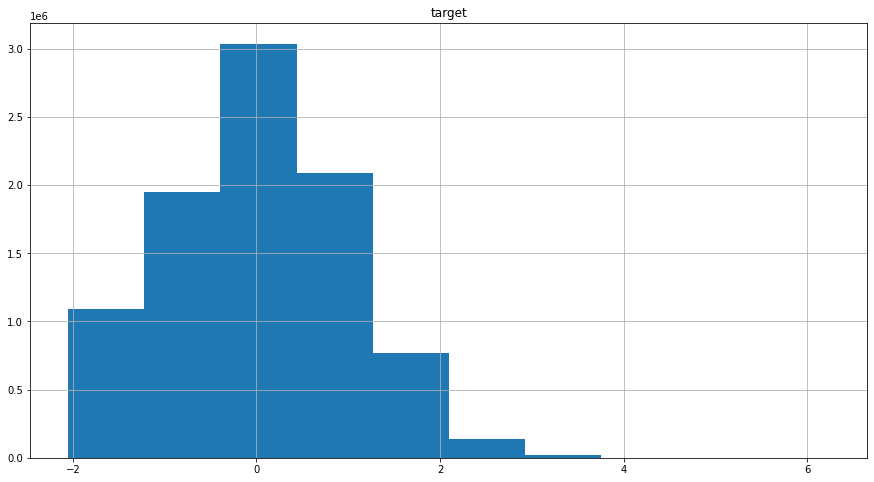

In [13]:
# Log Transformation
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
train[["target"]] = pd.DataFrame(
    pt.fit_transform(train[["target"]]), columns=["target"]
)

train[["target"]].hist(figsize=(15, 8));

In [ ]:
# 범주형이 아닌 column에 대해서만 정규화(#값을 0~1로 떨어뜨린다)
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

train_merge["timestamp"]= pd.to_datetime(train_merge["timestamp"])
test_merge["timestamp"]= pd.to_datetime(test_merge["timestamp"])
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
#train_scaled=train_merge
#train_scaled[['target','square_meter','temperature','dewpoint','rain','pressure','wind_speed']] = scaler.fit_transform(train_scaled[['target','square_meter','temperature','dewpoint','rain','pressure','wind_speed']])
#train_scaled

In [ ]:
test_merge.head()

,factory_id,timestamp,location_id,usage,square_meter,year_built,floor_count,temperature,cloud,dewpoint,rain,pressure,wind_direction,wind_speed,month,day,weekday,weekend,hour
0,0,2016-01-24,0,0,690,2008.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7,1,24,6,1,0
1,1,2016-01-24,0,0,252,2004.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7,1,24,6,1,0
2,2,2016-01-24,0,0,499,1991.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7,1,24,6,1,0
3,3,2016-01-24,0,0,2200,2002.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7,1,24,6,1,0
4,4,2016-01-24,0,0,10833,1975.0,NaN,7.2,2.0,1.7,0.0,1014.3,270.0,7.7,1,24,6,1,0


In [ ]:
test_scaled=test_merge
test_scaled[['square_meter','temperature','dewpoint','rain','pressure','wind_speed']] = scaler.fit_transform(test_scaled[['square_meter','temperature','dewpoint','rain','pressure','wind_speed']])
test_scaled.head()

,factory_id,timestamp,location_id,usage,square_meter,year_built,floor_count,temperature,cloud,dewpoint,rain,pressure,wind_direction,wind_speed,month,day,weekday,weekend,hour
0,0,2016-01-24,0,0,0.008171,2008.0,NaN,0.400966,2.0,0.48954,0.002907,0.54848,270.0,0.416216,1,24,6,1,0
1,1,2016-01-24,0,0,0.002781,2004.0,NaN,0.400966,2.0,0.48954,0.002907,0.54848,270.0,0.416216,1,24,6,1,0
2,2,2016-01-24,0,0,0.005821,1991.0,NaN,0.400966,2.0,0.48954,0.002907,0.54848,270.0,0.416216,1,24,6,1,0
3,3,2016-01-24,0,0,0.026753,2002.0,NaN,0.400966,2.0,0.48954,0.002907,0.54848,270.0,0.416216,1,24,6,1,0
4,4,2016-01-24,0,0,0.132988,1975.0,NaN,0.400966,2.0,0.48954,0.002907,0.54848,270.0,0.416216,1,24,6,1,0


In [42]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [52]:
train_gp = train.groupby(['factory_id','timestamp'], as_index=False)
train_gp = train_gp.agg({'target':['mean']})
train_gp.columns = ['factory_id','timestamp','target']
train_gp

,factory_id,timestamp,target
0,0,2016-01-01 00:00:00,0.000
1,0,2016-01-01 01:00:00,0.000
2,0,2016-01-01 02:00:00,0.000
3,0,2016-01-01 03:00:00,0.000
4,0,2016-01-01 04:00:00,0.000
...,...,...,...
9095335,1448,2016-12-23 19:00:00,3.425
9095336,1448,2016-12-23 20:00:00,3.225
9095337,1448,2016-12-23 21:00:00,3.650
9095338,1448,2016-12-23 22:00:00,3.875


In [53]:
# 일주일 예측(23*7 = 161)
window = 170
lag = 170

series = series_to_supervised(train_gp[:window].drop('timestamp', axis=1), window=window, lag=lag)
series

,factory_id(t-170),target(t-170),factory_id(t-169),target(t-169),factory_id(t-168),target(t-168),factory_id(t-167),target(t-167),factory_id(t-166),target(t-166),factory_id(t-165),target(t-165),factory_id(t-164),target(t-164),factory_id(t-163),target(t-163),factory_id(t-162),target(t-162),factory_id(t-161),target(t-161),factory_id(t-160),target(t-160),factory_id(t-159),target(t-159),factory_id(t-158),target(t-158),factory_id(t-157),target(t-157),factory_id(t-156),target(t-156),factory_id(t-155),target(t-155),factory_id(t-154),target(t-154),factory_id(t-153),target(t-153),factory_id(t-152),target(t-152),factory_id(t-151),target(t-151),...,factory_id(t-18),target(t-18),factory_id(t-17),target(t-17),factory_id(t-16),target(t-16),factory_id(t-15),target(t-15),factory_id(t-14),target(t-14),factory_id(t-13),target(t-13),factory_id(t-12),target(t-12),factory_id(t-11),target(t-11),factory_id(t-10),target(t-10),factory_id(t-9),target(t-9),factory_id(t-8),target(t-8),factory_id(t-7),target(t-7),factory_id(t-6),target(t-6),factory_id(t-5),target(t-5),factory_id(t-4),target(t-4),factory_id(t-3),target(t-3),factory_id(t-2),target(t-2),factory_id(t-1),target(t-1),factory_id(t),target(t),factory_id(t+170),target(t+170)


In [54]:
for i in range(1413):
    factory_id = train_gp.iloc[0]['factory_id']
    idx = train_gp[train_gp['factory_id']==factory_id].index
    temp_series = series_to_supervised(train_gp[train_gp['factory_id']==factory_id][:window*3].drop('timestamp', axis=1), window=window, lag=lag)
    # series와 temp_series 데이터프레임 합치기
    series = series.append(temp_series, ignore_index=True)
    train_gp = train_gp.drop(idx)

In [42]:
train_gp

,factory_id,timestamp,target


In [43]:
series

,factory_id(t-170),target(t-170),factory_id(t-169),target(t-169),factory_id(t-168),target(t-168),factory_id(t-167),target(t-167),factory_id(t-166),target(t-166),factory_id(t-165),target(t-165),factory_id(t-164),target(t-164),factory_id(t-163),target(t-163),factory_id(t-162),target(t-162),factory_id(t-161),target(t-161),factory_id(t-160),target(t-160),factory_id(t-159),target(t-159),factory_id(t-158),target(t-158),factory_id(t-157),target(t-157),factory_id(t-156),target(t-156),factory_id(t-155),target(t-155),factory_id(t-154),target(t-154),factory_id(t-153),target(t-153),factory_id(t-152),target(t-152),factory_id(t-151),target(t-151),...,factory_id(t-18),target(t-18),factory_id(t-17),target(t-17),factory_id(t-16),target(t-16),factory_id(t-15),target(t-15),factory_id(t-14),target(t-14),factory_id(t-13),target(t-13),factory_id(t-12),target(t-12),factory_id(t-11),target(t-11),factory_id(t-10),target(t-10),factory_id(t-9),target(t-9),factory_id(t-8),target(t-8),factory_id(t-7),target(t-7),factory_id(t-6),target(t-6),factory_id(t-5),target(t-5),factory_id(t-4),target(t-4),factory_id(t-3),target(t-3),factory_id(t-2),target(t-2),factory_id(t-1),target(t-1),factory_id(t),target(t),factory_id(t+170),target(t+170)
0,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,...,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0,-2.050916,0.0,-2.050916
1,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,...,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0,-2.050916,0.0,-2.050916
2,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,...,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0,-2.050916,0.0,-2.050916
3,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,...,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0,-2.050916,0.0,-2.050916
4,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,...,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.050916,0.0,-2.0509

In [15]:
# facotry_id 별로 묶은 행들만
window = 170
last_factory = 'factory_id(t-%d)' % window
series = series[(series['factory_id(t)'] == series[last_factory])]
len(series)

240040

In [16]:
# 범주형 데이터 factory_id 관련 column 삭제
columns_to_drop=[]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t+%d)' % (col, i)) for col in ['factory_id']]
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['factory_id']]
series.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
series.drop(['factory_id(t)'], axis=1, inplace=True, errors='ignore')
series

,target(t-170),target(t-169),target(t-168),target(t-167),target(t-166),target(t-165),target(t-164),target(t-163),target(t-162),target(t-161),target(t-160),target(t-159),target(t-158),target(t-157),target(t-156),target(t-155),target(t-154),target(t-153),target(t-152),target(t-151),target(t-150),target(t-149),target(t-148),target(t-147),target(t-146),target(t-145),target(t-144),target(t-143),target(t-142),target(t-141),target(t-140),target(t-139),target(t-138),target(t-137),target(t-136),target(t-135),target(t-134),target(t-133),target(t-132),target(t-131),...,target(t-38),target(t-37),target(t-36),target(t-35),target(t-34),target(t-33),target(t-32),target(t-31),target(t-30),target(t-29),target(t-28),target(t-27),target(t-26),target(t-25),target(t-24),target(t-23),target(t-22),target(t-21),target(t-20),target(t-19),target(t-18),target(t-17),target(t-16),target(t-15),target(t-14),target(t-13),target(t-12),target(t-11),target(t-10),target(t-9),target(t-8),target(t-7),target(t-6),target(t-5),target(t-4),target(t-3),target(t-2),target(t-1),target(t),target(t+170)
0,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,...,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916
1,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,...,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916
2,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,...,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916
3,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,...,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2.050916,-2

In [55]:
# facotry_id 별로 묶은 행들만
window = 170
last_factory = 'factory_id(t-%d)' % window
series = series[(series['factory_id(t)'] == series[last_factory])]
len(series)

240040

In [56]:
# 범주형 데이터 factory_id 관련 column 삭제
columns_to_drop=[]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t+%d)' % (col, i)) for col in ['factory_id']]
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['factory_id']]
series.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
#series.drop(['factory_id(t)'], axis=1, inplace=True, errors='ignore')
series

,target(t-170),target(t-169),target(t-168),target(t-167),target(t-166),target(t-165),target(t-164),target(t-163),target(t-162),target(t-161),target(t-160),target(t-159),target(t-158),target(t-157),target(t-156),target(t-155),target(t-154),target(t-153),target(t-152),target(t-151),target(t-150),target(t-149),target(t-148),target(t-147),target(t-146),target(t-145),target(t-144),target(t-143),target(t-142),target(t-141),target(t-140),target(t-139),target(t-138),target(t-137),target(t-136),target(t-135),target(t-134),target(t-133),target(t-132),target(t-131),...,target(t-37),target(t-36),target(t-35),target(t-34),target(t-33),target(t-32),target(t-31),target(t-30),target(t-29),target(t-28),target(t-27),target(t-26),target(t-25),target(t-24),target(t-23),target(t-22),target(t-21),target(t-20),target(t-19),target(t-18),target(t-17),target(t-16),target(t-15),target(t-14),target(t-13),target(t-12),target(t-11),target(t-10),target(t-9),target(t-8),target(t-7),target(t-6),target(t-5),target(t-4),target(t-3),target(t-2),target(t-1),factory_id(t),target(t),target(t+170)
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240035,3.500,2.600,3.700,4.300,3.075,3.400,2.825,3.225,4.750,4.975,5.875,5.050,4.975,4.700,5.400,4.425,4.175,4.325,4.400,4.450,5.475,4.150,3.225,3.000,2.450,2.475,2.900,2.475,2.875,2.425,2.450,2.550,2.8

In [57]:
series.to_csv('/content/drive/My Drive/fdai-test/series_o.csv', index=False)

In [8]:
series = pd.read_csv ('/content/drive/My Drive/fdai-test/series_o.csv')

# 5. Train/Validation Split

In [9]:
# Label
labels_col = 'target(t+%d)' % 170 # target(t+170)
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

# train: 60 validation 40
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)

print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

Train set shape (144024, 172)
Validation set shape (96016, 172)


# 6. MLP

In [35]:
epochs = 30 # 30번 반복학습
batch = 256 # 한 번에 256개씩 학습
lr = 0.0003 # learning rate는 0.0003
adam = optimizers.Adam(lr)

In [12]:
import tensorflow.keras.backend as K

def rmsle_custom(y_true, y_pred):
    msle = tensorflow.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

In [12]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss=rmsle_custom, optimizer=adam)

In [13]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               17300     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 17,401
Trainable params: 17,401
Non-trainable params: 0
_________________________________________________________________


In [14]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
4501/4501 - 9s - loss: 0.5432 - val_loss: 0.5009
Epoch 2/30
4501/4501 - 9s - loss: 0.5120 - val_loss: 0.4725
Epoch 3/30
4501/4501 - 9s - loss: 0.4757 - val_loss: 0.4850
Epoch 4/30
4501/4501 - 8s - loss: 0.4676 - val_loss: 0.4554
Epoch 5/30
4501/4501 - 9s - loss: 0.4627 - val_loss: 0.4895
Epoch 6/30
4501/4501 - 8s - loss: 0.4541 - val_loss: 0.4636
Epoch 7/30
4501/4501 - 9s - loss: 0.4502 - val_loss: 0.4933
Epoch 8/30
4501/4501 - 8s - loss: 0.4450 - val_loss: 0.4757
Epoch 9/30
4501/4501 - 8s - loss: 0.4426 - val_loss: 0.4774
Epoch 10/30
4501/4501 - 8s - loss: 0.4362 - val_loss: 0.4458
Epoch 11/30
4501/4501 - 8s - loss: 0.4362 - val_loss: 0.5199
Epoch 12/30
4501/4501 - 8s - loss: 0.4345 - val_loss: 0.4596
Epoch 13/30
4501/4501 - 8s - loss: 0.4303 - val_loss: 0.4664
Epoch 14/30
4501/4501 - 8s - loss: 0.4283 - val_loss: 0.4706
Epoch 15/30
4501/4501 - 8s - loss: 0.4252 - val_loss: 0.4430
Epoch 16/30
4501/4501 - 8s - loss: 0.4253 - val_loss: 0.4447
Epoch 17/30
4501/4501 - 8s - loss

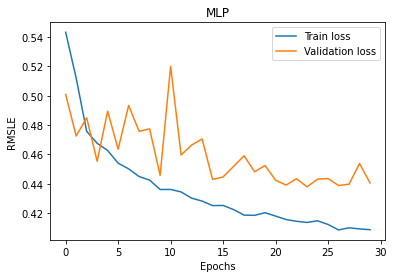

In [24]:
plt.plot(mlp_history.history['loss'], label='Train loss')
plt.plot(mlp_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.title('MLP')
plt.xlabel('Epochs')
plt.ylabel('RMSLE')
#plt.axis(ymin=0, ymax=0.5)
plt.show()

In [21]:
train_gp = train.groupby(['factory_id','timestamp'], as_index=False)
train_gp = train_gp.agg({'target':['mean']})
train_gp.columns = ['factory_id','timestamp','target']
train_gp

,factory_id,timestamp,target
0,0,2016-01-01 00:00:00,0.000
1,0,2016-01-01 01:00:00,0.000
2,0,2016-01-01 02:00:00,0.000
3,0,2016-01-01 03:00:00,0.000
4,0,2016-01-01 04:00:00,0.000
...,...,...,...
9095335,1448,2016-12-23 19:00:00,3.425
9095336,1448,2016-12-23 20:00:00,3.225
9095337,1448,2016-12-23 21:00:00,3.650
9095338,1448,2016-12-23 22:00:00,3.875


In [17]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)

# 예측 값이 0보다 작으면 0으로 만듦
mlp_train_pred[mlp_train_pred < 0] = 0
mlp_valid_pred[mlp_valid_pred < 0] = 0

Y_train_ = pd.DataFrame({'y_true':Y_train, 'y_pred': mlp_train_pred.reshape(mlp_train_pred.shape[0], )}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp, left_index=True, right_index=True, how='left')

Y_valid_ = pd.DataFrame({'y_true':Y_valid, 'y_pred': mlp_valid_pred.reshape(mlp_valid_pred.shape[0], )}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp, left_index=True, right_index=True, how='left')

## 6.2 Train / Validation 성능

In [11]:
from sklearn import metrics

def scoring(y_true, y_pred):
  r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
  corr = round(np.corrcoef(y_true, y_pred)[0,1],3)
  rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
  rmsle = round(metrics.mean_squared_log_error(y_true, y_pred), 3)

  df = pd.DataFrame({
      'R2' : r2,
      "Corr" : corr,
      "RMSE" : rmse,
      "RMSLE" : rmsle,
  }, index=[0])
  return df

In [17]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,RMSLE
0,97.388,0.987,56.593,0.256


In [18]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,RMSLE
0,89.235,0.945,117.349,0.297


In [13]:
def abline(slope, intercept):
  """Plot a line from slope and intercept"""
  axes = plt.gca()
  x_vals = np.array(axes.get_xlim())
  y_vals = intercept + slope * x_vals
  plt.plot(x_vals, y_vals, '--')

def MinMax(y_true, y_pred, m="min"):
  if (m=="min"):
    return min(min(y_true), min(y_pred)) - 2
  else:
    return max(max(y_true), max(y_pred)) + 2

def myGraph(temp, title):
  fig, axs = plt.subplots(1,2,figsize=(20,5), gridspec_kw={'width_ratios' : [2.5, 1]})
  axs[0].plot(temp.timestamp, temp.y_true, label="Original")
  axs[0].plot(temp.timestamp, temp.y_pred, label="Predicted")
  axs[0].legend(loc='upper right')
  axs[0].set_xlabel("Date")
  axs[0].set_ylabel("Sales")

  axs[1].plot(temp.y_true, temp.y_pred, '.')

  plt.xlim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, "max"))
  plt.ylim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, "max"))
  abline(1,0)
  plt.title(title)
  plt.xlabel("Original")
  plt.ylabel("Predicted")

## 6.3 factory_id=30

In [21]:
temp = Y_valid_.loc[(Y_valid_.factory_id == 30),].sort_values('timestamp')
print("Obs of Test Set : ", temp.shape[0])

Obs of Test Set :  2682


In [22]:
scoring(temp.y_true, temp.y_pred)

,R2,Corr,RMSE,RMSLE
0,97.947,0.99,28.581,0.082


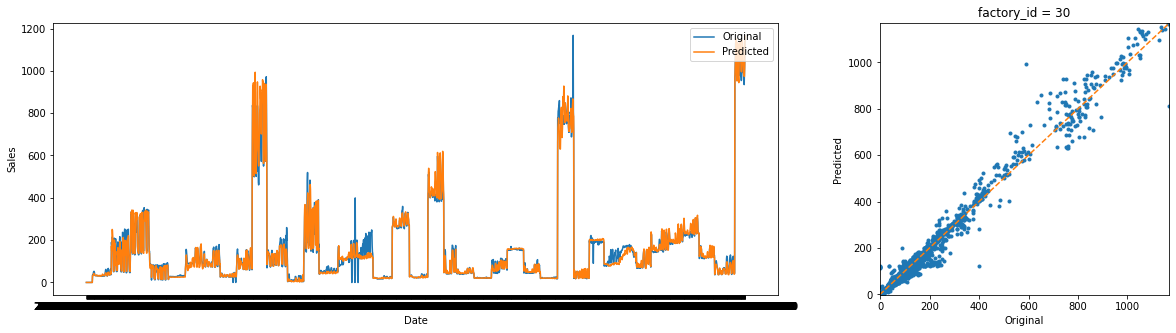

In [84]:
myGraph(temp, 'factory_id = %d' % 30)

# 7. CNN

In [15]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (144024, 172, 1)
Validation set shape (96016, 172, 1)


In [21]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss=rmsle_custom, optimizer=adam)

In [22]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 171, 64)           192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 85, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 5440)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                272050    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 272,293
Trainable params: 272,293
Non-trainable params: 0
_________________________________________________________________


In [23]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
4501/4501 - 14s - loss: 0.4940 - val_loss: 0.4663
Epoch 2/30
4501/4501 - 12s - loss: 0.4603 - val_loss: 0.4683
Epoch 3/30
4501/4501 - 12s - loss: 0.4518 - val_loss: 0.4551
Epoch 4/30
4501/4501 - 12s - loss: 0.4473 - val_loss: 0.4498
Epoch 5/30
4501/4501 - 12s - loss: 0.4455 - val_loss: 0.4476
Epoch 6/30
4501/4501 - 12s - loss: 0.4423 - val_loss: 0.4451
Epoch 7/30
4501/4501 - 12s - loss: 0.4392 - val_loss: 0.4431
Epoch 8/30
4501/4501 - 12s - loss: 0.4337 - val_loss: 0.4513
Epoch 9/30
4501/4501 - 12s - loss: 0.4317 - val_loss: 0.4420
Epoch 10/30
4501/4501 - 12s - loss: 0.4291 - val_loss: 0.4417
Epoch 11/30
4501/4501 - 12s - loss: 0.4259 - val_loss: 0.4401
Epoch 12/30
4501/4501 - 12s - loss: 0.4236 - val_loss: 0.4379
Epoch 13/30
4501/4501 - 12s - loss: 0.4224 - val_loss: 0.4371
Epoch 14/30
4501/4501 - 12s - loss: 0.4204 - val_loss: 0.4347
Epoch 15/30
4501/4501 - 12s - loss: 0.4182 - val_loss: 0.4368
Epoch 16/30
4501/4501 - 12s - loss: 0.4175 - val_loss: 0.4336
Epoch 17/30
4501/

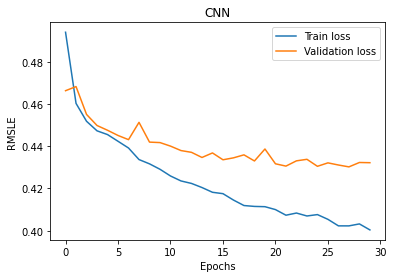

In [25]:
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.title('CNN')
plt.xlabel('Epochs')
plt.ylabel('RMSLE')
#plt.axis(ymin=0, ymax=0.5)
plt.show()

In [26]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)

# 예측 값이 0보다 작으면 0으로 만듦
cnn_train_pred[cnn_train_pred < 0] = 0
cnn_valid_pred[cnn_valid_pred < 0] = 0

Y_train_ = pd.DataFrame({'y_true':Y_train, 'y_pred': cnn_train_pred.reshape(cnn_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp, left_index=True, right_index=True, how='left')

Y_valid_ = pd.DataFrame({'y_true':Y_valid, 'y_pred': cnn_valid_pred.reshape(cnn_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp, left_index=True, right_index=True, how='left')

## 7.2 Train / Validation 성능

In [30]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,RMSLE
0,96.819,0.987,62.45,0.262


In [31]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,RMSLE
0,88.469,0.944,121.453,0.287


## 7.3 factory_id=30

In [32]:
temp = Y_valid_.loc[(Y_valid_.factory_id == 30),].sort_values('timestamp')
print("Obs of Test Set : ", temp.shape[0])

Obs of Test Set :  2682


In [33]:
scoring(temp.y_true, temp.y_pred)

,R2,Corr,RMSE,RMSLE
0,97.465,0.99,31.759,0.086


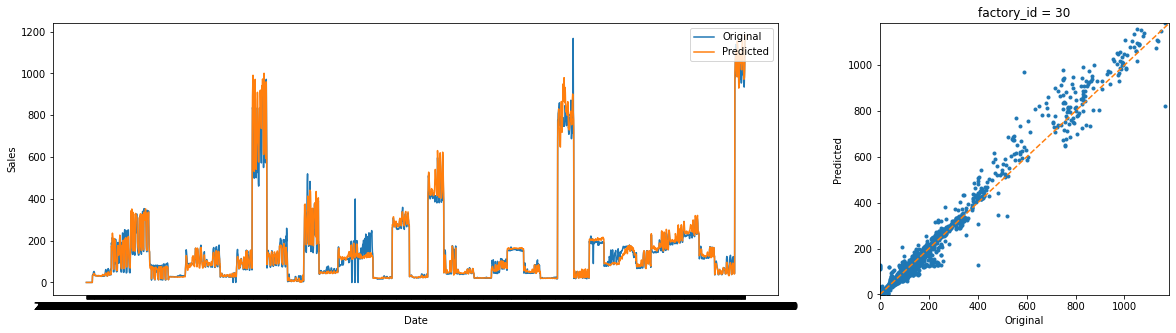

In [34]:
myGraph(temp, 'factory_id = %d' % 30)

# 8. LSTM

In [16]:
model_lstm = Sequential()
model_lstm.add(LSTM(30, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss=rmsle_custom, optimizer=adam)

In [17]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                3840      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [18]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=15, verbose=2)

Epoch 1/15
4501/4501 - 909s - loss: 2.7829 - val_loss: 2.5530
Epoch 2/15
4501/4501 - 904s - loss: 2.3433 - val_loss: 2.3304
Epoch 3/15
4501/4501 - 893s - loss: 2.2234 - val_loss: 2.1000
Epoch 4/15
4501/4501 - 894s - loss: 2.0048 - val_loss: 1.9264
Epoch 5/15
4501/4501 - 881s - loss: 1.8671 - val_loss: 1.8074
Epoch 6/15
4501/4501 - 875s - loss: 1.6832 - val_loss: 1.5987
Epoch 7/15
4501/4501 - 886s - loss: 1.5010 - val_loss: 1.4290
Epoch 8/15
4501/4501 - 882s - loss: 1.3604 - val_loss: 1.3120
Epoch 9/15
4501/4501 - 916s - loss: 1.2977 - val_loss: 1.2865
Epoch 10/15
4501/4501 - 942s - loss: 1.2482 - val_loss: 1.2179
Epoch 11/15
4501/4501 - 951s - loss: 1.1863 - val_loss: 1.1693
Epoch 12/15
4501/4501 - 944s - loss: 1.1424 - val_loss: 1.1058
Epoch 13/15
4501/4501 - 923s - loss: 1.1213 - val_loss: 1.1145
Epoch 14/15
4501/4501 - 937s - loss: 1.1057 - val_loss: 1.0667
Epoch 15/15
4501/4501 - 942s - loss: 1.0747 - val_loss: 1.0794


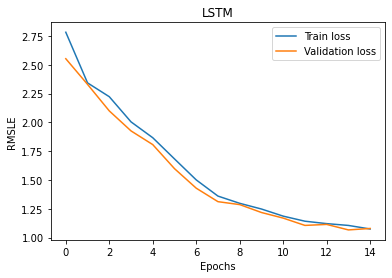

In [19]:
plt.plot(lstm_history.history['loss'], label='Train loss')
plt.plot(lstm_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('RMSLE')
#plt.axis(ymin=0, ymax=0.5)
plt.show()

In [23]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)

# 예측 값이 0보다 작으면 0으로 만듦
lstm_train_pred[lstm_train_pred < 0] = 0
lstm_valid_pred[lstm_valid_pred < 0] = 0

Y_train_ = pd.DataFrame({'y_true':Y_train, 'y_pred': lstm_train_pred.reshape(lstm_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp, left_index=True, right_index=True, how='left')

Y_valid_ = pd.DataFrame({'y_true':Y_valid, 'y_pred': lstm_valid_pred.reshape(lstm_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp, left_index=True, right_index=True, how='left')

## 8.2 Train / Validation 성능

In [24]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,RMSLE
0,36.386,0.827,279.288,1.214


In [25]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,RMSLE
0,33.287,0.784,292.127,1.211


## 8.3 factory_id=30

In [26]:
temp = Y_valid_.loc[(Y_valid_.factory_id == 30),].sort_values('timestamp')
print("Obs of Test Set : ", temp.shape[0])

Obs of Test Set :  2682


In [27]:
scoring(temp.y_true, temp.y_pred)

,R2,Corr,RMSE,RMSLE
0,15.132,0.5,183.763,0.787


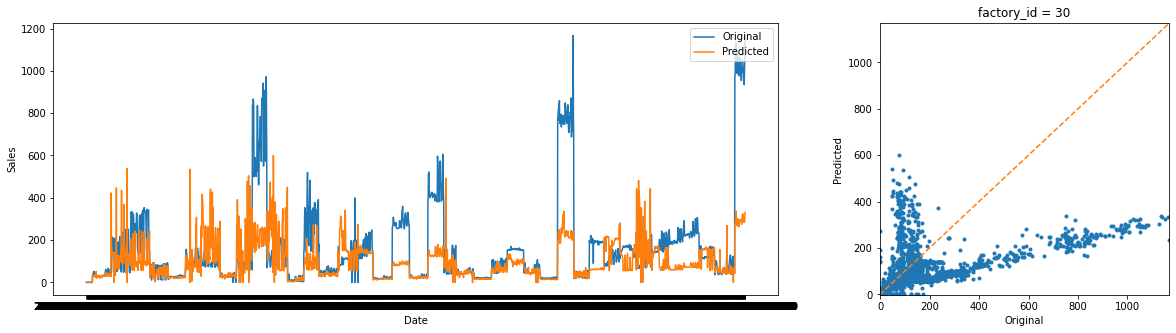

In [28]:
myGraph(temp, 'factory_id = %d' % 30)

# 9. CNN+LSTM

In [29]:
X_train_series.shape

(144024, 172, 1)

In [31]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))

print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (144024, 2, 86, 1)
Validation set shape (96016, 2, 86, 1)


In [36]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss=rmsle_custom, optimizer=adam)

In [37]:
model_cnn_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 86, 64)      128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 43, 64)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 2752)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                560600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 560,779
Trainable params: 560,779
Non-trainable params: 0
_________________________________________________________________


In [38]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
4501/4501 - 33s - loss: 0.4844 - val_loss: 0.4685
Epoch 2/30
4501/4501 - 32s - loss: 0.4647 - val_loss: 0.4687
Epoch 3/30
4501/4501 - 32s - loss: 0.4581 - val_loss: 0.4622
Epoch 4/30
4501/4501 - 32s - loss: 0.4542 - val_loss: 0.4616
Epoch 5/30
4501/4501 - 32s - loss: 0.4505 - val_loss: 0.4583
Epoch 6/30
4501/4501 - 32s - loss: 0.4500 - val_loss: 0.4643
Epoch 7/30
4501/4501 - 32s - loss: 0.4455 - val_loss: 0.4536
Epoch 8/30
4501/4501 - 32s - loss: 0.4416 - val_loss: 0.4477
Epoch 9/30
4501/4501 - 32s - loss: 0.4369 - val_loss: 0.4469
Epoch 10/30
4501/4501 - 31s - loss: 0.4362 - val_loss: 0.4461
Epoch 11/30
4501/4501 - 32s - loss: 0.4358 - val_loss: 0.4619
Epoch 12/30
4501/4501 - 33s - loss: 0.4351 - val_loss: 0.4463
Epoch 13/30
4501/4501 - 34s - loss: 0.4326 - val_loss: 0.4441
Epoch 14/30
4501/4501 - 34s - loss: 0.4307 - val_loss: 0.4428
Epoch 15/30
4501/4501 - 34s - loss: 0.4277 - val_loss: 0.4472
Epoch 16/30
4501/4501 - 33s - loss: 0.4273 - val_loss: 0.4428
Epoch 17/30
4501/

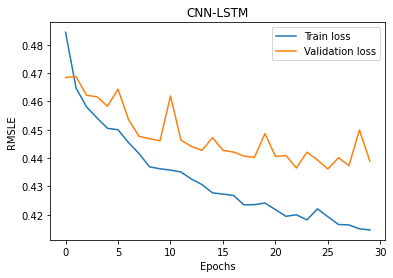

In [39]:
plt.plot(cnn_lstm_history.history['loss'], label='Train loss')
plt.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.title('CNN-LSTM')
plt.xlabel('Epochs')
plt.ylabel('RMSLE')
#plt.axis(ymin=0, ymax=0.5)
plt.show()

In [41]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)

# 예측 값이 0보다 작으면 0으로 만듦
cnn_lstm_train_pred[cnn_lstm_train_pred < 0] = 0
cnn_lstm_valid_pred[cnn_lstm_valid_pred < 0] = 0

Y_train_ = pd.DataFrame({'y_true':Y_train, 'y_pred':cnn_lstm_train_pred.reshape(cnn_lstm_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
Y_train_ = pd.merge(Y_train_, train_gp, left_index=True, right_index=True, how='left')

Y_valid_ = pd.DataFrame({'y_true':Y_valid, 'y_pred':cnn_lstm_valid_pred.reshape(cnn_lstm_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_gp, left_index=True, right_index=True, how='left')

## 9.2 Train / Validation 성능

In [42]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,RMSLE
0,97.331,0.987,57.207,0.266


In [43]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,RMSLE
0,89.139,0.945,117.868,0.293


## 9.3 factory_id=30

In [44]:
temp = Y_valid_.loc[(Y_valid_.factory_id == 30),].sort_values('timestamp')
print("Obs of Test Set : ", temp.shape[0])

Obs of Test Set :  2682


In [45]:
scoring(temp.y_true, temp.y_pred)

,R2,Corr,RMSE,RMSLE
0,97.51,0.989,31.48,0.085


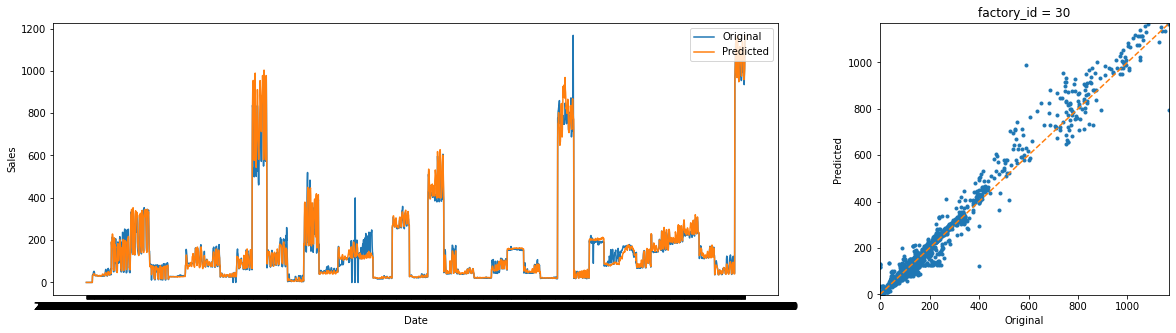

In [46]:
myGraph(temp, 'factory_id = %d' % 30)

# 10. 모든 모델 비교

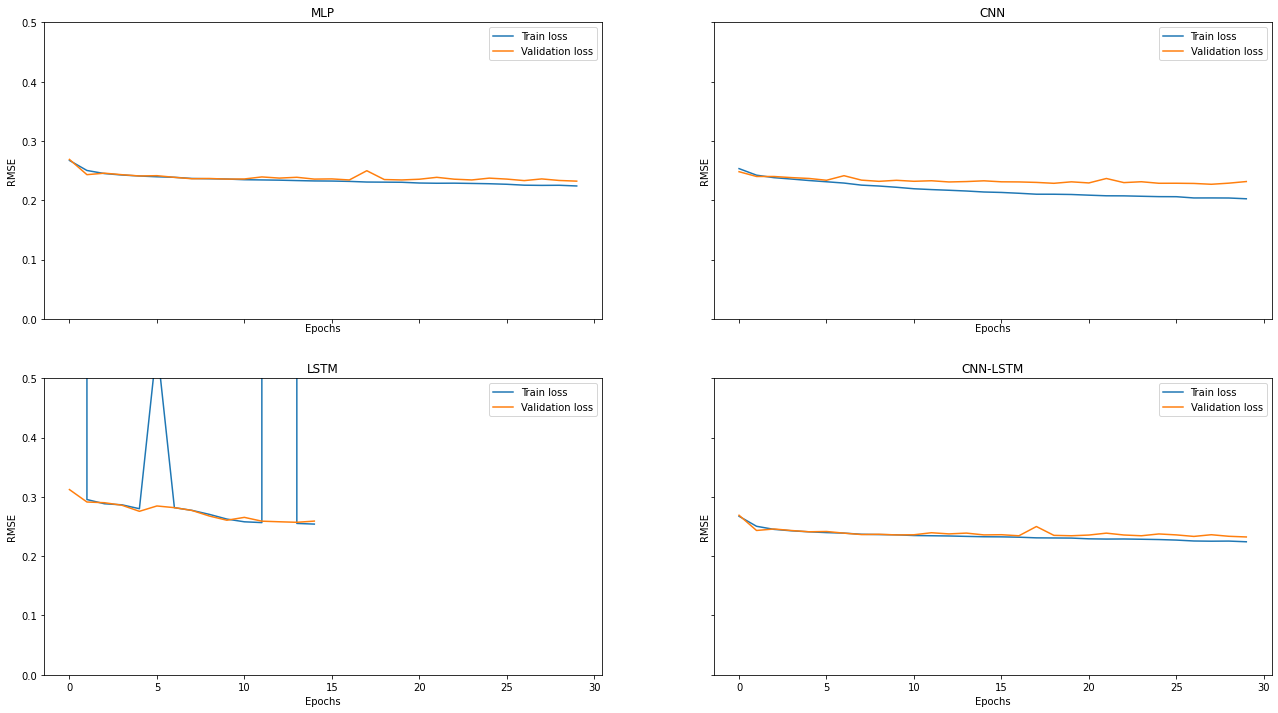

In [96]:
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(22,12))
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('RMSLE')
#ax1.axis(ymin=0, ymax=0.5)

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('RMSLE')
#ax2.axis(ymin=0, ymax=0.5)

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('RMSLE')
#ax3.axis(ymin=0, ymax=0.5)

ax4.plot(mlp_history.history['loss'], label='Train loss')
ax4.plot(mlp_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('RMSLE')
#ax4.axis(ymin=0, ymax=0.5)

plt.show()